###  data

In [5]:
import os
import pickle
import requests
import numpy as np

In [5]:
!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

--2024-07-11 18:48:23--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
正在解析主机 raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
正在连接 raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... 已连接。
已发出 HTTP 请求，正在等待回应... 200 OK
长度：1115394 (1.1M) [text/plain]
正在保存至: “input.txt”

input.txt           100%[===================>]   1.06M  1.92MB/s  用时 0.6s      

2024-07-11 18:48:24 (1.92 MB/s) - 已保存 “input.txt” [1115394/1115394])



In [30]:
with open('input.txt','r', encoding='utf-8') as f:
    text = f.read()


In [31]:
len(text)

1115394

In [32]:
print(text[:100])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You


In [33]:
chars = sorted(list(set(text)))
vocab_size = (len(chars))
print(chars)
print(vocab_size)

['\n', ' ', '!', '$', '&', "'", ',', '-', '.', '3', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
65


In [34]:
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
def encode(s):
    return [stoi[c] for c in s] # encoder: take a string, output a list of integers
def decode(l):
    return ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

In [35]:
encode('adf') , decode([1,2,3])

([39, 42, 44], ' !$')

In [36]:
import torch 


In [37]:
data = torch.tensor(encode(text), dtype=torch.long)

In [38]:
data.shape, data.dtype 

(torch.Size([1115394]), torch.int64)

In [39]:
data[:100]

tensor([18, 47, 56, 57, 58,  1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 14, 43, 44,
        53, 56, 43,  1, 61, 43,  1, 54, 56, 53, 41, 43, 43, 42,  1, 39, 52, 63,
         1, 44, 59, 56, 58, 46, 43, 56,  6,  1, 46, 43, 39, 56,  1, 51, 43,  1,
        57, 54, 43, 39, 49,  8,  0,  0, 13, 50, 50, 10,  0, 31, 54, 43, 39, 49,
         6,  1, 57, 54, 43, 39, 49,  8,  0,  0, 18, 47, 56, 57, 58,  1, 15, 47,
        58, 47, 64, 43, 52, 10,  0, 37, 53, 59])

In [40]:
decode(data[:100].tolist())

'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou'

In [41]:
n = int(0.9*len(data))
train_data = data[:n]
val_data = data[n:]

In [42]:
len(train_data), len(val_data)

(1003854, 111540)

In [43]:
block_size = 8
train_data[:block_size+1]

tensor([18, 47, 56, 57, 58,  1, 15, 47, 58])

In [44]:
torch.manual_seed(1337)

In [45]:
batch_size = 4
block_size = 8


In [46]:
ix = torch.randint(len(data)-block_size, (batch_size,))
ix

tensor([1078327,  453969,   41646,  671252])

In [47]:
def get_batch(split):
    data = train_data if split =='train' else val_data
    ix = torch.randint(len(data)-block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    return x, y 



In [48]:
xb,yb = get_batch('train')


In [49]:
xb.shape , yb.shape

(torch.Size([4, 8]), torch.Size([4, 8]))

In [50]:
for b in range(batch_size):
    for t in range(block_size):
        context = xb[b, :t+1]
        target = yb[b,t]
        print(f"input:{context.tolist()}, output:{target} ")


input:[57], output:43 
input:[57, 43], output:60 
input:[57, 43, 60], output:43 
input:[57, 43, 60, 43], output:52 
input:[57, 43, 60, 43, 52], output:1 
input:[57, 43, 60, 43, 52, 1], output:63 
input:[57, 43, 60, 43, 52, 1, 63], output:43 
input:[57, 43, 60, 43, 52, 1, 63, 43], output:39 
input:[60], output:43 
input:[60, 43], output:42 
input:[60, 43, 42], output:8 
input:[60, 43, 42, 8], output:0 
input:[60, 43, 42, 8, 0], output:25 
input:[60, 43, 42, 8, 0, 25], output:63 
input:[60, 43, 42, 8, 0, 25, 63], output:1 
input:[60, 43, 42, 8, 0, 25, 63, 1], output:45 
input:[56], output:42 
input:[56, 42], output:5 
input:[56, 42, 5], output:57 
input:[56, 42, 5, 57], output:1 
input:[56, 42, 5, 57, 1], output:57 
input:[56, 42, 5, 57, 1, 57], output:39 
input:[56, 42, 5, 57, 1, 57, 39], output:49 
input:[56, 42, 5, 57, 1, 57, 39, 49], output:43 
input:[43], output:57 
input:[43, 57], output:58 
input:[43, 57, 58], output:63 
input:[43, 57, 58, 63], output:6 
input:[43, 57, 58, 63, 6],

### base model

In [51]:
import torch
import torch.nn as nn 
from torch.nn import functional as F
torch.manual_seed(1337)

In [1144]:
class BigramLanguageModel(nn.Module):

    def __init__(self, vocab_size):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, vocab_size)

    def forward(self, idx, targets=None):
        # idx and targets are both (B,T) tensor of integers, idx and targets are both (B,T) tensor of integers
        logits = self.token_embedding_table(idx) # (B,T,C)
        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)   # (B*T,C)
            targets = targets.view(B*T)    
            loss = F.cross_entropy(logits, targets)
        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # get the predictions
            logits, loss = self.forward(idx)   # ：当执行model(x)的时候，底层自动调用forward方法计算结果
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)  取第二维的最后一个元素
            # print(logits.shape)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx



In [1145]:
print(vocab_size)
model = BigramLanguageModel(vocab_size)
logits , loss = model(xb, yb)
print(logits.shape) 
print(loss)

65
torch.Size([32, 65])
tensor(4.7879, grad_fn=<NllLossBackward>)


In [1146]:
### generate
idx = torch.zeros((1,1), dtype=torch.long)
out_idx = model.generate(idx  , max_new_tokens= 100)
decode(out_idx[0].tolist())

"\nt$HsPh'JaH;VtouIuAliN' Mw,DfUf:peYbv!PiVOZm!URmRmPKd?vg?sM3M?umF3obmjhdzP mBcCH KCaQm OfYVsBKBC'.&EI"

### train model 

In [1140]:
### optimizer 
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

In [1147]:
# train 
train_steps  = 10000
for step in range(train_steps):
    xb, yb = get_batch('train')
    logits, loss = m(xb, yb)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
print(loss.item())


4.444241046905518


In [72]:
idx = torch.zeros((1,1), dtype=torch.long)
idx[:,-1:]

tensor([[0]])

In [1183]:
### generate from trained model 
idx = torch.zeros((1,1), dtype=torch.long)
out_idx = model.generate(idx  , max_new_tokens= 10)
decode(out_idx[0].tolist())

'\nD?PFXLTIdm'

### attention 计算

In [17]:
torch.manual_seed(1337)
B,T,C = 4,8,2 # batch , time, channels
x = torch.randn(B,T,C)
x.shape

torch.Size([4, 8, 2])

In [18]:
# version 1 
xbow = torch.zeros((B,T,C))
for b in range(B):
    for t in range(T):
        xprev = x[b, :t+1]  # (t, C)
        xbow[b,t] = torch.mean(xprev, 0)
    
        

In [19]:
# version 2 
wei = torch.tril(torch.ones(T,T))
wei = wei/ wei.sum(1, keepdim=True)
xbow2 = wei @ x
torch.allclose(xbow, xbow2)  # 比较两个tensor是否足够接近

True

In [20]:
a = torch.tril(torch.ones(5,5), diagonal=0)
a.shape
a

tensor([[1., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0.],
        [1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1.]])

In [21]:
# version 3 
tril = torch.tril((torch.ones(T,T)))
wei = torch.zeros((T,T))
wei = wei.masked_fill(tril==0 , float('-inf'))
wei
wei = F.softmax(wei, dim=1)
wei
xbow3 = wei @ x # @ =torch.matmul() 矩阵乘法
torch.allclose(xbow, xbow3)

True

In [58]:
# version4 self -attention 
torch.manual_seed(1337)
B,T,C = 4,8,32 # batch , time, channels
x = torch.randn(B,T,C)

head_size = 16
key = nn.Linear(C, head_size, bias=False)
query = nn.Linear(C, head_size , bias=False)


k = key(x) # (B,T,head_size=16)
q = query(x) # (B,T,head_size=16)

wei = q @ k.transpose(-2,-1) # (B,T,16) @ (B,16,T) -> (B,T,T)
tril = torch.tril(torch.ones(T,T))
wei = wei.masked_fill(tril ==0, float('-inf'))
wei = F.softmax(wei,dim=-1)
out = wei@x

out.shape




torch.Size([4, 8, 32])

### self attention model

In [77]:
class Head(nn.Module):
    """one head of  self attention"""
    
    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd,head_size,bias=False)
        self.query = nn.Linear(n_embd , head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril',torch.tril(torch.ones(block_size,block_size)))
    
    def forward(self,x):
        B,T,C = x.shape 
        k = self.key(x) # （B,T,C)
        q = self.query(x) # (B,T,C)
        wei = q @ k.transpose(-2,-1) * C ** -0.5 # （B,T,C) @ (B,C,T) -> (B,T,T)
        wei = wei.masked_fill(self.tril[:T,:T] == 0  , float('-inf'))
        wei = F.softmax(wei, dim=-1)
        v = self.value(x)
        out = wei @ x 
        return out 

In [78]:
class BigramLanguageModel(nn.Module):

    def __init__(self, vocab_size):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.sa_head = Head(n_embd)
        self.lm_head = nn.Linear(n_embd, vocab_size)


    def forward(self, idx, targets=None):
        B,T = idx.shape
        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T,device=device))
        x = tok_emb + pos_emb  # (B,T,C)
        x = self.sa_head(x)   # 
        logits = self.lm_head(x)    # (B,T,vocab_size)
        
        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)   # (B*T,C)
            targets = targets.view(B*T)    
            loss = F.cross_entropy(logits, targets)
        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = id[:, -block_size:] 
            # get the predictions
            logits, loss = self.forward(idx)   # ：当执行model(x)的时候，底层自动调用forward方法计算结果
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)  取第二维的最后一个元素
            # print(logits.shape)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx



In [84]:
# hyper-parameters
batch_size = 32 
block_size = 8 
max_iters = 5000 
eval_interval = 500
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 32 

B,T,C = batch_size,block_size,n_embd # batch , time, channels

In [89]:
print(vocab_size)
model = BigramLanguageModel(vocab_size)
logits , loss = model(xb, yb)
print(logits.shape) 
print(loss)

65
torch.Size([32, 65])
tensor(4.4743, grad_fn=<NllLossBackward>)


In [92]:
### generate from trained model 
idx = torch.zeros((1,1), dtype=torch.long)
out_idx = model.generate(idx  , max_new_tokens= 10)
decode(out_idx[0].tolist())

TypeError: 'builtin_function_or_method' object is not subscriptable

In [81]:
### optimizer 
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

### multi - head attention model

In [10]:
class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in paraller"""
    def __init__(self,num_heads , head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
    
    def forward(slef, x ):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out= self.proj(out)
        return 
    

In [14]:
class FeedForward(nn.Module):
    "linear laryer and a Relu"
    def __init__(self, n_embd):
        super().__init__()
        self.net == nn.Sequential(
            nn.Linear(n_embd,4*n_embd),
            nn.Relu(),
            nn.Linear(4*n_embd, n_embd),
        )
    def forward(self,x):
        return self.net(x)

In [11]:
class LanguageModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.token_embeddding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embddind_table = nn.Embedding(block_size,n_embd)
        self.sa_heads =  MultiHeadAttention(4, n_embd//4)
        self.ffwd = FeedForward(n_embd)
        self.lm_head = nn.Linear(n_embd, vocab_size)
    
    def forward(self,idx,targets=None):
        B, T = idx.shape
        token_embd = self.token_embeddding_table(idx)
        pos_embd = self.position_embddind_table(torch.arange(T,device=device))
        x = token_embd + pos_embd
        x = self.sa_heads(x)
        x = self.ffwd(x)
        logits = self.lm_head(x)
        if targets is None:
            loss = None 
        else:
            B,T, C = logits.shape
            logits = logits.view(B*T,C)
            targets = targets.view(B*T)  
            loss = F.cross_entropy(logits, targets)
        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = id[:, -block_size:] 
            # get the predictions
            logits, loss = self.forward(idx)   # ：当执行model(x)的时候，底层自动调用forward方法计算结果
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)  取第二维的最后一个元素
            # print(logits.shape)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx
            



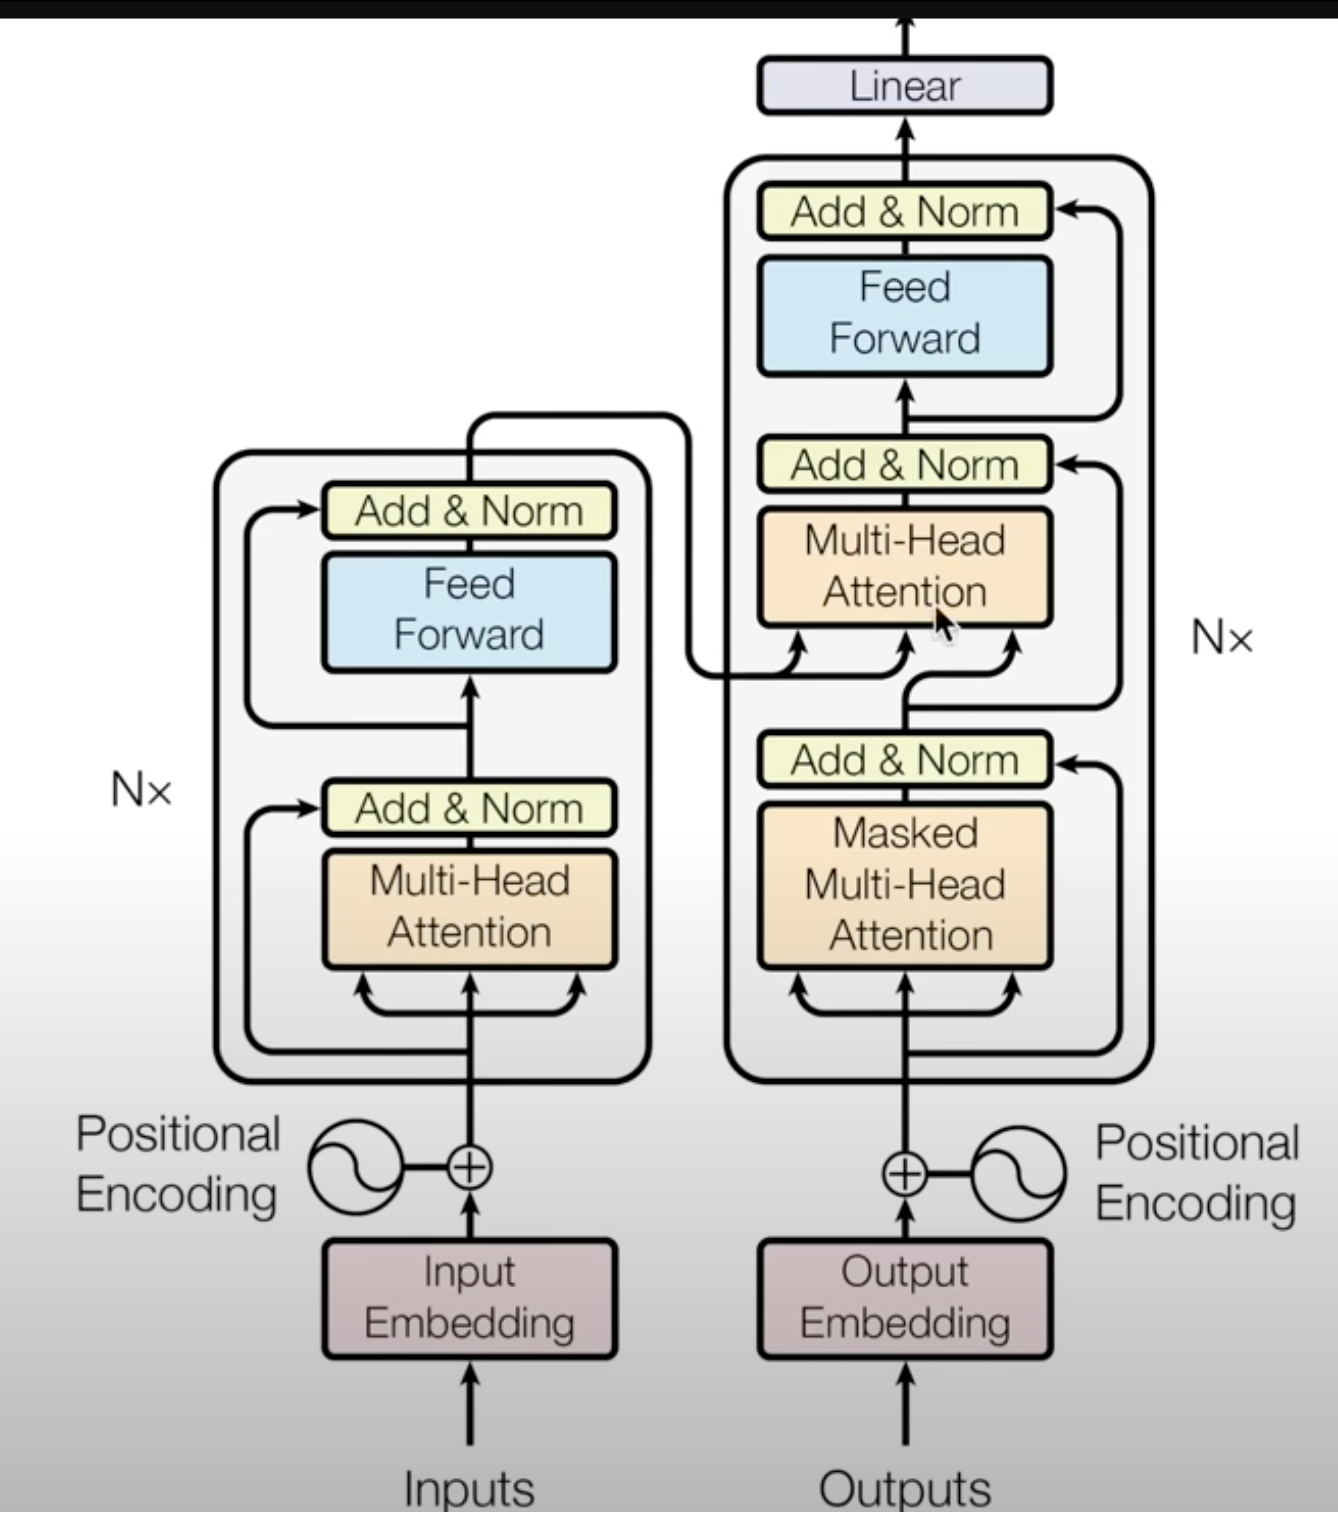

In [15]:
# 多个block

class Block(nn.Module):
    def __init__(self):
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd  = FeedForward(n_embd)

    def forward(self,x): 
        x = x + self.sa(x)   # resnet 
        x = x + self.ffwd(x)
        return x 

In [16]:
class LanguageModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.token_embeddding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embddind_table = nn.Embedding(block_size,n_embd)
        self.blocks = nn.Sequential(
            Block(n_embd, n_head=4),
            Block(n_embd, n_head=4),
            Block(n_embd, n_head=4),
            nn.LayerNorm(n_embd),
        )
        self.lm_head = nn.Linear(n_embd, vocab_size)
    
    def forward(self,idx,targets=None):
        B, T = idx.shape
        token_embd = self.token_embeddding_table(idx)
        pos_embd = self.position_embddind_table(torch.arange(T,device=device))
        x = token_embd + pos_embd
        x = self.blocks(x)
        logits = self.lm_head(x)
        if targets is None:
            loss = None 
        else:
            B,T, C = logits.shape
            logits = logits.view(B*T,C)
            targets = targets.view(B*T)  
            loss = F.cross_entropy(logits, targets)
        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = id[:, -block_size:] 
            # get the predictions
            logits, loss = self.forward(idx)   # ：当执行model(x)的时候，底层自动调用forward方法计算结果
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)  取第二维的最后一个元素
            # print(logits.shape)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx
            

